<a href="https://colab.research.google.com/github/kiarsie/eq-forecast/blob/main/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install scipy
!pip install cartopy
!pip install geopy
!pip install pycsep

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATASET PREPROCESSING MAKING IT [CSEP](*https*://docs.cseptesting.org) COMPATIBLE:

In [6]:
import pandas as pd
import numpy as np
from csep.core.catalogs import CSEPCatalog
from csep.utils.time_utils import datetime_to_utc_epoch

df = pd.read_csv('/content/drive/MyDrive/OPAL/eq_catalog.csv', encoding='utf-8-sig')

#print(df.columns)    -->FOR CHECKING

#print((df == '').sum())  -->FOR CHECKING

#  COMBINE TO DATE_TIME & DROP ORIGINAL COLS
df['Date_Time'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']], errors='coerce')
df = df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'])

#print(df.columns)    -->FOR CHECKING

#  RENAME FOR CSEP
df = df.rename(columns={
    'N_Lat': 'latitude',
    'E_Long': 'longitude',
    'Mag': 'magnitude',
    'Depth': 'depth'
})

#  DROP ROW WITH MISSING DATE_TIME
print(df[df['Date_Time'].isnull()].index)

df = df[df['Date_Time'].notnull()]

#  LOCALIZE TO MANILA AND CONVERT TO UTF
df['Date_Time'] = df['Date_Time'].dt.tz_localize('Asia/Manila', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')

#  CONVERT UTC TO EPOCH TIME
df['origin_time'] = df['Date_Time'].apply(datetime_to_utc_epoch)

#  ADD ID COL
df = df.reset_index().rename(columns={'index': 'id'})

print(df['longitude'].min(), df['longitude'].max())




Index([], dtype='int64')
116.3 133.0


NameError: name 'catalog' is not defined

In [7]:
import pandas as pd
import numpy as np
from csep.core.catalogs import CSEPCatalog
from csep.utils.time_utils import datetime_to_utc_epoch

df = pd.read_csv('/content/drive/MyDrive/OPAL/eq_catalog.csv', encoding='utf-8-sig')

#print(df.columns)    -->FOR CHECKING

#print((df == '').sum())  -->FOR CHECKING

#  COMBINE TO DATE_TIME & DROP ORIGINAL COLS
df['Date_Time'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']], errors='coerce')
df = df.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'])

#print(df.columns)    -->FOR CHECKING

#  RENAME FOR CSEP
df = df.rename(columns={
    'N_Lat': 'latitude',
    'E_Long': 'longitude',
    'Mag': 'magnitude',
    'Depth': 'depth'
})

#  DROP ROW WITH MISSING DATE_TIME
print(df[df['Date_Time'].isnull()].index)

df = df[df['Date_Time'].notnull()]

#  LOCALIZE TO MANILA AND CONVERT TO UTF
df['Date_Time'] = df['Date_Time'].dt.tz_localize('Asia/Manila', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')

#  CONVERT UTC TO EPOCH TIME
df['origin_time'] = df['Date_Time'].apply(datetime_to_utc_epoch)

#  ADD ID COL
df = df.reset_index().rename(columns={'index': 'id'})

#  CREATE CATALOG
catalog = CSEPCatalog.from_dataframe(df)

print(catalog)

Index([], dtype='int64')

        Name: None

        Start Date: 1909-04-25 14:36:00+00:00
        End Date: 2025-01-22 19:41:13+00:00

        Latitude: (2.0, 22.0)
        Longitude: (116.3, 133.0)

        Min Mw: nan
        Max Mw: nan

        Event Count: 3509
        


PLOTTING 3X3 CARTESIAN GRID

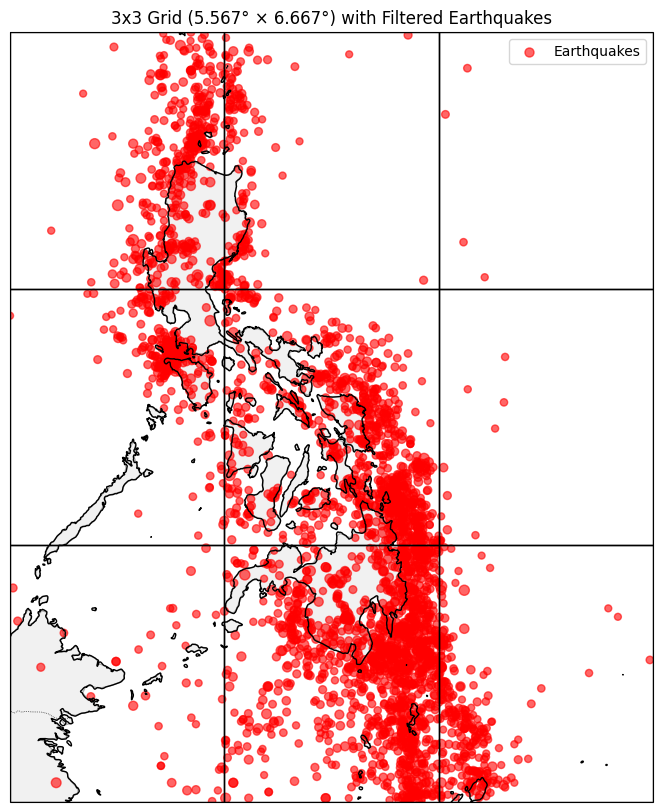

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from csep.core.catalogs import CSEPCatalog
from csep.utils.time_utils import datetime_to_utc_epoch
from csep.core.regions import CartesianGrid2D

#  SET BOUNDS AND RESOLUTION
min_lon, max_lon = 116.3, 133.0
min_lat, max_lat = 2.0, 22.0
dh_lon = (max_lon - min_lon) / 3  # ~5.567°
dh_lat = (max_lat - min_lat) / 3  # ~6.667°

#  CREATING GRID CELL CENTERS
lon_edges = np.arange(min_lon, max_lon, dh_lon)
lat_edges = np.arange(min_lat, max_lat, dh_lat)
lon_centers = lon_edges + dh_lon / 2
lat_centers = lat_edges + dh_lat / 2
lon_mesh, lat_mesh = np.meshgrid(lon_centers, lat_centers)
origins = np.column_stack((lon_mesh.ravel(), lat_mesh.ravel()))

#  LOADING CATALOG COORDINATES
lons = catalog.get_longitudes()
lats = catalog.get_latitudes()

#  MANUAL MASKING PER CELL
mask = np.full(len(lons), False)
for origin in origins:
    in_lon = (lons >= origin[0] - dh_lon / 2) & (lons < origin[0] + dh_lon / 2)
    in_lat = (lats >= origin[1] - dh_lat / 2) & (lats < origin[1] + dh_lat / 2)
    mask |= (in_lon & in_lat)

#  FILTERING AND CREATING NEW DF
filtered_mags = catalog.get_magnitudes()[mask]
filtered_depths = catalog.get_depths()[mask] if catalog.get_depths() is not None else np.full(np.sum(mask), np.nan)
filtered_times = [datetime_to_utc_epoch(dt) for dt in np.array(catalog.get_datetimes())[mask]]

df = pd.DataFrame({
    'id': np.arange(np.sum(mask)),
    'magnitude': filtered_mags,
    'latitude': lats[mask],
    'longitude': lons[mask],
    'depth': filtered_depths,
    'origin_time': filtered_times
})

#  DUMMY REGION TO SATISFY CSEP REQUIREMENT
dummy_region = CartesianGrid2D.from_origins(
    origins=np.array([[min_lon, min_lat]]),
    dh=1.0
)

#  WRAP INTO NEW CSEP CATALOG
filtered_catalog = CSEPCatalog.from_dataframe(df, region=dummy_region)

'''
if filtered_catalog.get_number_of_events() == 0:
    print("Warning: Filtered catalog is empty. Check your grid bounds or masking logic.")  ---> FOR CHECKING
'''

#  PLOTTING
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

#  MAP FEATURES
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', alpha=0.3)

#  EQ EVENTS
ax.scatter(
    filtered_catalog.get_longitudes(),
    filtered_catalog.get_latitudes(),
    s=filtered_catalog.get_magnitudes()**2,
    color='red',
    alpha=0.6,
    label='Earthquakes',
    transform=ccrs.PlateCarree()
)

#  GRID CELLS
for origin in origins:
    rect = plt.Rectangle(
        (origin[0] - dh_lon / 2, origin[1] - dh_lat / 2),
        width=dh_lon,
        height=dh_lat,
        edgecolor='black',
        facecolor='none',
        linewidth=1,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)


ax.set_title(f"3x3 Grid ({dh_lon:.3f}° × {dh_lat:.3f}°) with Filtered Earthquakes")
ax.legend()
plt.show()
